# Model Testing and Comparison Notebook

This notebook provides a framework for testing and comparing different machine learning models for movie genre classification.

## Features:
- Easy model configuration and testing
- Automatic metric calculation and comparison
- Visualization of results
- Support for multiple model types (Logistic Regression, XGBoost, etc.)


In [5]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    hamming_loss, jaccard_score, confusion_matrix
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
import time
from typing import Dict, List, Tuple, Any
import json

# Try importing XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available. Install with: pip install xgboost")

# Project imports
from descriptions.config import INTERIM_DATA_DIR, MODELS_DIR
from descriptions.dataset import load_interim
from descriptions.modeling.train import prepare_features_and_labels
from descriptions.modeling.preprocess import load_preprocessors

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All imports successful")


✓ XGBoost available
✓ All imports successful


## 1. Load and Prepare Data


In [6]:
# Load and prepare data
print("Loading data...")
data = load_interim(INTERIM_DATA_DIR / "cleaned_movies.csv")
print(f"✓ Loaded {len(data)} samples")
print(f"Columns: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())

# Split data into train and test sets BEFORE preprocessing (prevents data leakage)
RANDOM_STATE = 42
TEST_SIZE = 0.2
X, y = data['description'], data['genre']

print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("✓ Data split complete")


Loading data...
2025-12-10 23:22:51.777 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2025-12-10 23:22:51.843 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2025-12-10 23:22:51.844 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples
Columns: ['genre', 'description']

First few rows:
                                     genre  \
movie_name                                   
he_hawshank_edemption         Drama, Crime   
he_odfather                   Drama, Crime   
he_odfather_art_              Drama, Crime   
chindlers_ist          Drama, History, War   
12_ngry_en                           Drama   

                                                             description  
movie_name                                                                
he

In [7]:
# Preprocess data: TF-IDF features and multi-label encoding
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

# Convert genre strings to lists of genre strings
def preprocess_genres(genre_series):
    """Convert genre strings to lists of genre strings."""
    return genre_series.fillna("").astype(str).str.split(r"\s*,\s*").apply(
        lambda genres: sorted({g.strip() for g in genres if g.strip()})
    )

print("Preprocessing genres...")
y_train_list = preprocess_genres(y_train)
y_test_list = preprocess_genres(y_test)

print(f"Sample y_train: {y_train_list.iloc[0]}")
print(f"Sample y_test: {y_test_list.iloc[0]}")

# Transform text to TF-IDF features
print("\nTransforming text to TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 2), 
    stop_words='english'
)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

print(f"✓ TF-IDF features: {X_train.shape[1]} features")

# Transform genres to binary labels
print("\nTransforming genres to binary labels...")
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_list)
y_test = mlb.transform(y_test_list)

print(f"✓ Binary labels: {y_train.shape[1]} genres")
print(f"✓ Training labels shape: {y_train.shape}")
print(f"✓ Test labels shape: {y_test.shape}")


kbest = SelectKBest(score_func=chi2, k=4500)
X_train = kbest.fit_transform(X_train, y_train)
X_test = kbest.transform(X_test)

print(f"✓ KBest selected {X_train.shape[1]} features")
print(f"✓ Training features shape: {X_train.shape}")
print(f"✓ Test features shape: {X_test.shape}")


svd = TruncatedSVD(n_components=2000, random_state=42)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

print(f"✓ SVD reduced to {X_train.shape[1]} features")
print(f"✓ Training features shape: {X_train.shape}")
print(f"✓ Test features shape: {X_test.shape}")



Preprocessing genres...
Sample y_train: ['Horror', 'Mystery']
Sample y_test: ['Adventure', 'Science Fiction', 'Western']

Transforming text to TF-IDF features...
✓ TF-IDF features: 10000 features

Transforming genres to binary labels...
✓ Binary labels: 18 genres
✓ Training labels shape: (7269, 18)
✓ Test labels shape: (1818, 18)
✓ KBest selected 4500 features
✓ Training features shape: (7269, 4500)
✓ Test features shape: (1818, 4500)
✓ SVD reduced to 2000 features
✓ Training features shape: (7269, 2000)
✓ Test features shape: (1818, 2000)


In [8]:
## 2. LinearSVC Grid Search and Evaluation

# Import required modules
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from descriptions.modeling.evaluate import evaluate_model

# Create base model with OneVsRestClassifier for multi-label classification
model_svc = OneVsRestClassifier(LinearSVC(random_state=42, dual=False))
param_grid = {
    'estimator__C': [0.01, 0.05, 0.1, 0.5],
    'estimator__penalty': ['l1','l2'],
    'estimator__loss': ['squared_hinge'],
    'estimator__max_iter': [1000, 2000],
    'estimator__tol': [1e-3, 1e-4],
    'estimator__class_weight': ['balanced', None],
}

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Total parameter combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")
print(f"Estimated time: ~{total_combinations * 5 * 0.5 / 60:.1f} minutes")

# Create custom scorer for multi-label classification (micro-averaged F1)
def multi_label_f1_micro(y_true, y_pred):
    """Custom scorer for multi-label F1 micro."""
    return f1_score(y_true, y_pred, average='micro', zero_division=0)

scorer = make_scorer(multi_label_f1_micro)

# Grid Search with cross-validation
print("\nStarting Grid Search for LinearSVC...")
print(f"Testing parameter combinations with 5-fold CV")
print("="*60)

grid_search_svc = GridSearchCV(
    estimator=model_svc,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search_svc.fit(X_train, y_train)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)
print(f"Best parameters: {grid_search_svc.best_params_}")
print(f"Best cross-validation score (F1 micro): {grid_search_svc.best_score_:.4f}")
print("="*60)

# Get the best model
best_model_svc = grid_search_svc.best_estimator_

# Evaluate the best model
print("\nEvaluating Best LinearSVC Model...")
metrics_svc = evaluate_model(best_model_svc, X_test, y_test)

print("\n" + "="*60)
print("BEST LINEARSVC METRICS (Test Set)")
print("="*60)
print(f"  F1 Score:       {metrics_svc['f1']:.4f} ({metrics_svc['f1']*100:.2f}%)")
print(f"  Precision:      {metrics_svc['precision']:.4f} ({metrics_svc['precision']*100:.2f}%)")
print(f"  Recall:         {metrics_svc['recall']:.4f} ({metrics_svc['recall']*100:.2f}%)")
print(f"  Hamming Loss:   {metrics_svc['hamming_loss']:.4f} ({metrics_svc['hamming_loss']*100:.2f}%)")
print(f"  Jaccard Score:  {metrics_svc['jaccard']:.4f} ({metrics_svc['jaccard']*100:.2f}%)")
print("="*60)

# Store for comparison
test_metrics = metrics_svc
train_metrics = evaluate_model(best_model_svc, X_train, y_train)



Total parameter combinations: 64
With 5-fold CV: 320 model fits
Estimated time: ~2.7 minutes

Starting Grid Search for LinearSVC...
Testing parameter combinations with 5-fold CV
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resou

[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=1000, estimator__penalty=l1, estimator__tol=0.001; total time= 1.3min
[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=1000, estimator__penalty=l1, estimator__tol=0.001; total time= 1.3min
[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=1000, estimator__penalty=l1, estimator__tol=0.0001; total time= 1.3min
[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=1000, estimator__penalty=l1, estimator__tol=0.0001; total time= 1.3min
[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=1000, estimator__penalty=l1, estimator__tol=0.001; total time= 1.3min
[CV] END estimator__C=0.01, estimator__class_weight=balanced, estimator__loss=squar

## 3. Overfitting Analysis: Cross-Validation, Learning Curves, and Validation Curves


### 3.3. Validation Curve

VALIDATION CURVE ANALYSIS
Testing C values: [ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]

Computing validation curve (this may take a few minutes)...


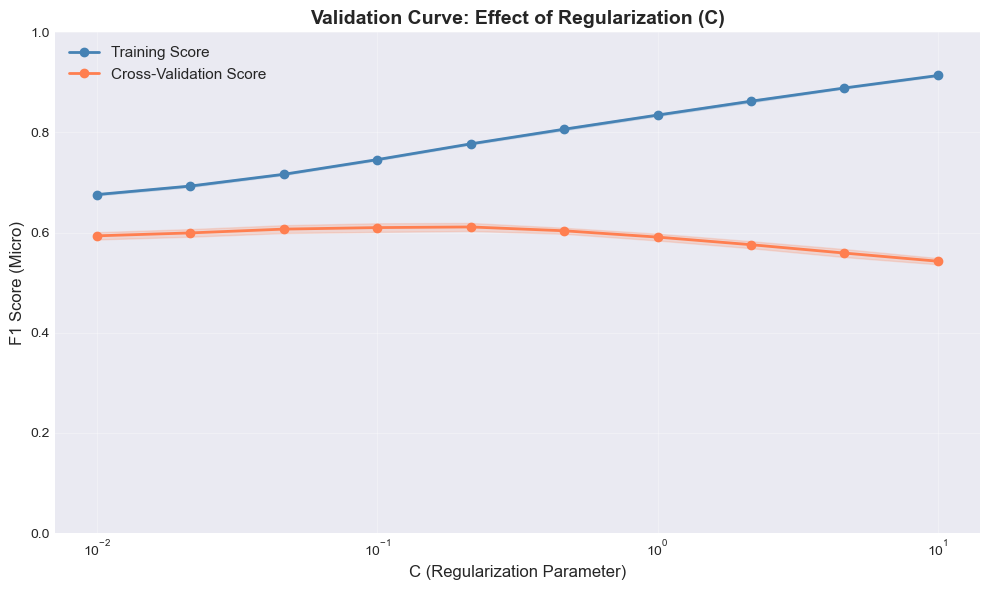


Validation Curve Analysis:
  Optimal C: 0.2154
  Optimal CV Score: 0.6114
  Current C (from grid search): 0.1
  ✓ Current C is close to optimal


In [9]:
# Validation Curve: How model performance changes with regularization parameter C
print("=" * 70)
print("VALIDATION CURVE ANALYSIS")
print("=" * 70)

from sklearn.model_selection import validation_curve

# Test different C values
C_range = np.logspace(-2, 1, 10)  # From 0.01 to 10
print(f"Testing C values: {C_range}")

# Create base model for validation curve
base_model = OneVsRestClassifier(LinearSVC(random_state=42, dual=False, max_iter=1000, class_weight='balanced'))

print("\nComputing validation curve (this may take a few minutes)...")

# Compute validation curve
train_scores_vc, val_scores_vc = validation_curve(
    base_model,
    X_train,
    y_train,
    param_name='estimator__C',
    param_range=C_range,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score, average='micro', zero_division=0),
    n_jobs=-1
)

# Calculate mean and std
train_scores_mean_vc = train_scores_vc.mean(axis=1)
train_scores_std_vc = train_scores_vc.std(axis=1)
val_scores_mean_vc = val_scores_vc.mean(axis=1)
val_scores_std_vc = val_scores_vc.std(axis=1)

# Plot validation curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(C_range, train_scores_mean_vc, 'o-', color='steelblue', label='Training Score', linewidth=2)
ax.fill_between(C_range, train_scores_mean_vc - train_scores_std_vc, train_scores_mean_vc + train_scores_std_vc, alpha=0.2, color='steelblue')
ax.semilogx(C_range, val_scores_mean_vc, 'o-', color='coral', label='Cross-Validation Score', linewidth=2)
ax.fill_between(C_range, val_scores_mean_vc - val_scores_std_vc, val_scores_mean_vc + val_scores_std_vc, alpha=0.2, color='coral')
ax.set_xlabel('C (Regularization Parameter)', fontsize=12)
ax.set_ylabel('F1 Score (Micro)', fontsize=12)
ax.set_title('Validation Curve: Effect of Regularization (C)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])
plt.tight_layout()
plt.show()

# Find optimal C
optimal_idx = np.argmax(val_scores_mean_vc)
optimal_C = C_range[optimal_idx]
optimal_score = val_scores_mean_vc[optimal_idx]

print(f"\nValidation Curve Analysis:")
print(f"  Optimal C: {optimal_C:.4f}")
print(f"  Optimal CV Score: {optimal_score:.4f}")
print(f"  Current C (from grid search): {grid_search_svc.best_params_['estimator__C']}")
if abs(optimal_C - grid_search_svc.best_params_['estimator__C']) > 0.5:
    print(f"  ⚠ Consider retraining with C={optimal_C:.4f} for potentially better performance")
else:
    print(f"  ✓ Current C is close to optimal")

### 3.4. Final Metrics Summary DataFrame

In [10]:
# Compile all metrics into a comprehensive DataFrame
print("=" * 70)
print("FINAL METRICS SUMMARY")
print("=" * 70)

# Check if cv_summary exists (from section 3.1), if not, compute it
if 'cv_summary' not in globals():
    print("Note: Computing cross-validation metrics (cv_summary not found)...")
    from sklearn.model_selection import cross_validate
    
    scoring = {
        'f1_micro': make_scorer(f1_score, average='micro', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
        'precision_micro': make_scorer(precision_score, average='micro', zero_division=0),
        'recall_micro': make_scorer(recall_score, average='micro', zero_division=0),
        'hamming_loss': make_scorer(hamming_loss),
    }
    
    cv_results = cross_validate(
        best_model_svc,
        X_train,
        y_train,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    cv_summary = {}
    for metric in ['f1_micro', 'f1_macro', 'precision_micro', 'recall_micro', 'hamming_loss']:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        cv_summary[metric] = {
            'train_mean': train_scores.mean(),
            'train_std': train_scores.std(),
            'test_mean': test_scores.mean(),
            'test_std': test_scores.std(),
            'gap': train_scores.mean() - test_scores.mean(),
        }

# Get test set metrics
test_metrics_final = evaluate_model(best_model_svc, X_test, y_test)
train_metrics_final = evaluate_model(best_model_svc, X_train, y_train)

# Create comprehensive metrics DataFrame
metrics_data = {
    'Metric': [
        'F1 Score (Micro)',
        'F1 Score (Macro)',
        'Precision (Micro)',
        'Recall (Micro)',
        'Hamming Loss',
        'Jaccard Score',
    ],
    'Train': [
        train_metrics_final['f1'],
        f1_score(y_train, best_model_svc.predict(X_train), average='macro', zero_division=0),
        train_metrics_final['precision'],
        train_metrics_final['recall'],
        train_metrics_final['hamming_loss'],
        train_metrics_final['jaccard'],
    ],
    'Test': [
        test_metrics_final['f1'],
        f1_score(y_test, best_model_svc.predict(X_test), average='macro', zero_division=0),
        test_metrics_final['precision'],
        test_metrics_final['recall'],
        test_metrics_final['hamming_loss'],
        test_metrics_final['jaccard'],
    ],
    'CV Mean': [
        cv_summary['f1_micro']['test_mean'],
        cv_summary['f1_macro']['test_mean'],
        cv_summary['precision_micro']['test_mean'],
        cv_summary['recall_micro']['test_mean'],
        cv_summary['hamming_loss']['test_mean'],
        None,  # Jaccard not in CV summary
    ],
    'CV Std': [
        cv_summary['f1_micro']['test_std'],
        cv_summary['f1_macro']['test_std'],
        cv_summary['precision_micro']['test_std'],
        cv_summary['recall_micro']['test_std'],
        cv_summary['hamming_loss']['test_std'],
        None,
    ],
    'Overfitting Gap': [
        train_metrics_final['f1'] - test_metrics_final['f1'],
        f1_score(y_train, best_model_svc.predict(X_train), average='macro', zero_division=0) - 
        f1_score(y_test, best_model_svc.predict(X_test), average='macro', zero_division=0),
        train_metrics_final['precision'] - test_metrics_final['precision'],
        train_metrics_final['recall'] - test_metrics_final['recall'],
        train_metrics_final['hamming_loss'] - test_metrics_final['hamming_loss'],
        train_metrics_final['jaccard'] - test_metrics_final['jaccard'],
    ],
}

final_metrics_df = pd.DataFrame(metrics_data)

# Format the DataFrame for better readability
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
print("\nFinal Metrics Summary:")
print(final_metrics_df.to_string(index=False))

# Add model parameters summary
print("\n" + "=" * 70)
print("MODEL PARAMETERS")
print("=" * 70)
print(f"Best Parameters from Grid Search:")
for param, value in grid_search_svc.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nModel Performance Summary:")
print(f"  Train F1: {train_metrics_final['f1']:.4f}")
print(f"  Test F1: {test_metrics_final['f1']:.4f}")
print(f"  CV F1 Mean: {cv_summary['f1_micro']['test_mean']:.4f} ± {cv_summary['f1_micro']['test_std']:.4f}")
print(f"  Overfitting Gap: {train_metrics_final['f1'] - test_metrics_final['f1']:.4f}")
print("=" * 70)

FINAL METRICS SUMMARY
Note: Computing cross-validation metrics (cv_summary not found)...
2025-12-11 00:26:07.312 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:116 - Evaluating model: X shape (1818, 2000), y shape (1818, 18)
2025-12-11 00:26:07.314 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:125 - Generating predictions from model...
2025-12-11 00:26:07.402 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:127 - Predictions generated: shape (1818, 18)
2025-12-11 00:26:07.402 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:130 - Calculating evaluation metrics (micro-averaged)...
2025-12-11 00:26:07.439 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:145 - Evaluation metrics calculated successfully
2025-12-11 00:26:07.441 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:116 - Evaluating model: X shape (7269, 2000), y shape (7269, 18)
2025-12-11 00:26:07.441 | DEBUG    | descriptions.modeling.evaluate:evaluate_model:125 -

### 3.1. Cross-Validation for Overfitting Analysis


In [11]:
# Cross-Validation for Overfitting Analysis
print("=" * 70)
print("CROSS-VALIDATION OVERFITTING ANALYSIS")
print("=" * 70)

from sklearn.model_selection import cross_validate

# Use the best model from grid search
print(f"Using best model with parameters: {grid_search_svc.best_params_}")

# Define scoring metrics for cross-validation
scoring = {
    'f1_micro': make_scorer(f1_score, average='micro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'precision_micro': make_scorer(precision_score, average='micro', zero_division=0),
    'recall_micro': make_scorer(recall_score, average='micro', zero_division=0),
    'hamming_loss': make_scorer(hamming_loss),
}

# Perform cross-validation with return_train_score=True to detect overfitting
print("\nPerforming 5-fold cross-validation...")
cv_results = cross_validate(
    best_model_svc,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Calculate mean and std for each metric
cv_summary = {}
for metric in ['f1_micro', 'f1_macro', 'precision_micro', 'recall_micro', 'hamming_loss']:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    cv_summary[metric] = {
        'train_mean': train_scores.mean(),
        'train_std': train_scores.std(),
        'test_mean': test_scores.mean(),
        'test_std': test_scores.std(),
        'gap': train_scores.mean() - test_scores.mean(),
    }

# Display cross-validation results
print("\n" + "=" * 70)
print("CROSS-VALIDATION RESULTS (5-fold)")
print("=" * 70)
print(f"{'Metric':<20} {'Train Mean':<12} {'Train Std':<12} {'Test Mean':<12} {'Test Std':<12} {'Gap':<10}")
print("-" * 70)
for metric, stats in cv_summary.items():
    print(f"{metric:<20} {stats['train_mean']:>10.4f}   {stats['train_std']:>10.4f}   "
          f"{stats['test_mean']:>10.4f}   {stats['test_std']:>10.4f}   {stats['gap']:>8.4f}")

# Overfitting assessment
overfitting_gap = cv_summary['f1_micro']['gap']
print("\n" + "=" * 70)
print("OVERFITTING ASSESSMENT")
print("=" * 70)
if overfitting_gap < 0.05:
    print(f"✓ EXCELLENT: Overfitting gap is {overfitting_gap:.4f} (< 0.05)")
elif overfitting_gap < 0.10:
    print(f"✓ GOOD: Overfitting gap is {overfitting_gap:.4f} (< 0.10)")
elif overfitting_gap < 0.15:
    print(f"⚠ MODERATE: Overfitting gap is {overfitting_gap:.4f} (0.10-0.15)")
else:
    print(f"⚠ HIGH: Overfitting gap is {overfitting_gap:.4f} (> 0.15)")
print("=" * 70)


CROSS-VALIDATION OVERFITTING ANALYSIS
Using best model with parameters: {'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__penalty': 'l2', 'estimator__tol': 0.001}

Performing 5-fold cross-validation...

CROSS-VALIDATION RESULTS (5-fold)
Metric               Train Mean   Train Std    Test Mean    Test Std     Gap       
----------------------------------------------------------------------
f1_micro                 0.7458       0.0015       0.6101       0.0086     0.1357
f1_macro                 0.7490       0.0020       0.5459       0.0173     0.2031
precision_micro          0.6550       0.0025       0.5485       0.0074     0.1065
recall_micro             0.8659       0.0005       0.6875       0.0131     0.1784
hamming_loss             0.0867       0.0008       0.1290       0.0023    -0.0423

OVERFITTING ASSESSMENT
⚠ MODERATE: Overfitting gap is 0.1357 (0.10-0.15)


### 3.2. Learning Curve


In [12]:
# Learning Curve: How model performance changes with training set size
print("=" * 70)
print("LEARNING CURVE ANALYSIS")
print("=" * 70)

from sklearn.model_selection import learning_curve

# Define training sizes (percentages of training data)
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs = (train_sizes * X_train.shape[0]).astype(int)

print(f"Training sizes: {train_sizes_abs}")
print("\nComputing learning curve (this may take a few minutes)...")

# Compute learning curve
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model_svc,
    X_train,
    y_train,
    train_sizes=train_sizes_abs,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score, average='micro', zero_division=0),
    n_jobs=-1,
    random_state=42
)

# Calculate mean and std
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot learning curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='steelblue', label='Training Score', linewidth=2)
ax.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='steelblue')
ax.plot(train_sizes_abs, val_scores_mean, 'o-', color='coral', label='Cross-Validation Score', linewidth=2)
ax.fill_between(train_sizes_abs, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='coral')
ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('F1 Score (Micro)', fontsize=12)
ax.set_title('Learning Curve: LinearSVC', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])
plt.tight_layout()
plt.show()

# Analyze learning curve
final_gap = train_scores_mean[-1] - val_scores_mean[-1]
print(f"\nLearning Curve Analysis:")
print(f"  Final training score: {train_scores_mean[-1]:.4f}")
print(f"  Final CV score: {val_scores_mean[-1]:.4f}")
print(f"  Gap: {final_gap:.4f}")
if val_scores_mean[-1] < val_scores_mean[-2]:
    print("  ⚠ Model may be overfitting (CV score decreasing)")
elif final_gap > 0.10:
    print(f"  ⚠ Large gap ({final_gap:.4f}) suggests overfitting")
else:
    print(f"  ✓ Good generalization (gap: {final_gap:.4f})")


LEARNING CURVE ANALYSIS
Training sizes: [ 726 1453 2180 2907 3634 4361 5088 5815 6542 7269]

Computing learning curve (this may take a few minutes)...


ValueError: train_sizes has been interpreted as absolute numbers of training samples and must be within (0, 5815], but is within [726, 7269].